# Comparison of GLIF models for my implementation and that in Teeter et al. (2018)


## Run Allen simulation

In [101]:
### Adapted from https://github.com/AllenInstitute/GLIF_Teeter_et_al_2018 ###
from pathlib import Path
import numpy as np
import pickle
import os
import allensdk.core.json_utilities as ju
from allensdk.model.glif.glif_neuron import GlifNeuron
from allensdk.core.cell_types_cache import CellTypesCache
import sys
import time
from GLIF_Teeter_et_al_2018.libraries.data_library import get_file_path_endswith, get_sweep_num_by_name
import json
import matplotlib.pyplot as plt 
from pygenn.genn_model import create_custom_current_source_class

relative_path=os.path.dirname(os.getcwd())
ctc = CellTypesCache(manifest_file=os.path.join(relative_path,'cell_types_manifest.json'))

GLIF_dict = {
    "LIF_model":"GLIF1",
    "LIFR_model":"GLIF2",
    "LIFASC_model":"GLIF3",
    "LIFRASC_model":"GLIF4",
    "LIFRASCAT_model":"GLIF5"}

def get_model(path, EW):
    '''Runs the model for a specified neuron and model
    inputs:
        path: string
            folder path with files for the neuron
        EW: string
            end of file searching for:  options '_GLIF1_neuron_config.json',_GLIF2_neuron_config.json' etc.
    returns:
        run_data: dictionary
            contains data from the model run
            
   '''

    specimen_id=int(os.path.basename(path)[:9])
    file=get_file_path_endswith(path, EW)

    # load data
    dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
    all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
    sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
    
    noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
    noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])

    # run model with current
    stimulus2=noise2_data['stimulus']
    neuron_config=ju.read(file)
    neuron_config['dt']=1./noise2_data['sampling_rate'] #reset dt to the stimulus dt not the optimization dt
    neuron = GlifNeuron.from_dict(neuron_config)
    1/noise2_data['sampling_rate']
    run_data = neuron.run(stimulus2)
    run_data['time']=np.arange(0, len(run_data['voltage']))*neuron_config['dt']
    run_data['El_reference']=neuron_config['El_reference']    
    run_data['stimulus']=noise2_data['stimulus']

    return run_data

def make_and_save_model(specimen_id, model_type):
    '''Runs models and creates resulting voltage waveforms and saves them to a pickle file
    inputs:
        specimen_id: integer
            specifies neuron to be run
        model_type: string
            specifies which type of GLIF model
    outputs:
        pickle files
    '''
    
    global start_time #grab start_time from outside this module
    
    # finding the folder associated with the desired specimen_id 
    for dir in folders:
        sp_id=int(os.path.basename(dir)[:9])
        if sp_id == specimen_id:
            folder=dir
    cre=os.path.basename(folder)[10:]
    
    try:
        os.makedirs('pkl_data')
    except: pass

    print('running {}'.format(model_type))
    config_name = '_{}_neuron_config.json'.format(GLIF_dict[model_type])
    LIF_model=get_model(folder, config_name)
    save_name = "pkl_data/"+str(specimen_id)+cre+"_{}.pkl".format(model_type)
    with open(save_name, 'wb') as f:
        pickle.dump(LIF_model, f)
    print('{} done at'.format(GLIF_dict[model_type]),(time.time()-start_time)/60., 'min')

path=os.path.join('./GLIF_Teeter_et_al_2018','mouse_struc_data_dir')
folders=[os.path.join(path, f) for f in  os.listdir(path)]

start_time=time.time()

specimen_ids = [474637203, 512322162]
model_types = ['LIF_model', 'LIFR_model', 'LIFASC_model', 'LIFRASC_model', 'LIFRASCAT_model']
saved_models = [f.name for f in Path('./pkl_data').glob('*')]

for specimen_id in specimen_ids:
    for model_type in model_types:

        for model in saved_models:

            # Skip if model already run and saved
            if model.startswith(str(specimen_id)) and model.endswith("_{}.pkl".format(model_type)):
                print("Already saved {}".format(model))
                break

        else:
            make_and_save_model(specimen_id, model_type)

Already saved 474637203Htr3a-Cre_NO152_LIF_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFR_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFASC_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFRASC_model.pkl
Already saved 474637203Htr3a-Cre_NO152_LIFRASCAT_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIF_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFR_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFASC_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFRASC_model.pkl
Already saved 512322162Ctgf-2A-dgCre_LIFRASCAT_model.pkl


## Run GeNN simulation

swig/python detected a memory leak of type 'CodeGenerator::SingleThreadedCPU::Backend *', no destructor found.
make: Nothing to be done for `all'.


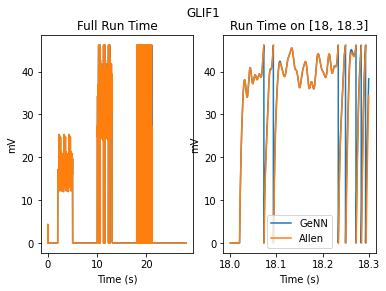

In [103]:
specimen_ids = [474637203]#, 512322162]
model_types = ['LIF_model'] #, 'LIFR_model', 'LIFASC_model', 'LIFRASC_model', 'LIFRASCAT_model']
saved_models = [f.name for f in Path('./pkl_data').glob('*')]

for specimen_id in specimen_ids:
    for model_type in model_types:
        
        # Find saved Allen model
        for model in saved_models:
            if model.startswith(str(specimen_id)) and model.endswith("_{}.pkl".format(model_type)):
                break
        else:
            raise ValueError("Allen run data not found for specimen: {0} and model type: {1}".format(specimen_id, model_type))

        # Load
        filename = Path('pkl_data', model)
        with open(filename, 'rb') as f:
            saved_model = pickle.load(f)

        # Load config
        for dir in folders:
            sp_id=int(os.path.basename(dir)[:9])
            if sp_id == specimen_id:
                folder=dir
        cre=os.path.basename(folder)[10:]   
        filename = Path(folder, Path(folder).parts[-1] + "_{}_neuron_config.json".format(GLIF_dict[model_type]))   
        with open(filename) as f:
            config = json.load(f)

        # Get stimulus dt, as config file's dt is optimization dt
        dir_name=os.path.join(relative_path, 'mouse_nwb/specimen_'+ str(specimen_id))
        all_sweeps=ctc.get_ephys_sweeps(specimen_id,  os.path.join(dir_name, 'ephys_sweeps.json'))
        sweeps=get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_sweeps = get_sweep_num_by_name(all_sweeps, 'Noise 2')
        noise2_data=ctc.get_ephys_data(specimen_id, os.path.join(dir_name, 'ephys.nwb')).get_sweep(noise2_sweeps[0])
        stimulus=noise2_data['stimulus']
        config['dt']=1./noise2_data['sampling_rate']

        # Convert Allen Units (SI) to PyGenn
        units_dict = {
            'C': config['C'] * 1e9,  # F -> nF
            'G': 1 / config['R_input'] * 1e6,  # S -> uS
            'El': config['El'] * 1e3, # V -> mV
            'V_thres': config['th_inf'] * config['coeffs']['th_inf'] * 1e3, # V -> mV
            'dT' : config['dt'] * 1e3,  # s -> ms
            'V': config['init_voltage'] * 1e3,  # V -> mV
        }

        # Add GLIF Class to model
        from GLIF_models import *
        num_neurons = 1
        GLIF = eval(GLIF_dict[model_type])
        GLIF_params = {k:units_dict[k] for k in GLIF.get_param_names()}
        GLIF_init = {k:units_dict[k] for k in ['V']}
        model = GeNNModel("float", GLIF_dict[model_type])
        model.dT=units_dict['dT']
        pop1 = model.add_neuron_population(
            pop_name = "pop1",
            num_neurons = num_neurons,
            neuron = GLIF,
            param_space = GLIF_params,
            var_space = GLIF_init,
        )

        ### Add current source to model ###
        external_current_source = create_custom_current_source_class(
            class_name = "external_current",
            var_name_types = [("current", "float") ],  
            injection_code = """
            $(current)=$(Ie)[int($(t) / DT)];
            $(injectCurrent,$(current) );
            """,
            extra_global_params=[("Ie", "float*")]
        )
        cs_ini = {"current":0.0}  # external input current from Teeter 2018
        cs = model.add_current_source(
            cs_name = "external_current_source", 
            current_source_model=external_current_source,
            pop = pop1,
            param_space = {},
            var_space = cs_ini)

        scale = 1e9  # amps -> nanoamps
        cs.set_extra_global_param("Ie", stimulus*scale)

        model.build()
        model.load()

        # Run a quick simulation
        num_steps = len(stimulus)
        v = np.empty((num_steps, num_neurons))
        v_view = pop1.vars["V"].view
        for i in range(num_steps):
            model.step_time()
            pop1.pull_var_from_device("V")            
            v[model.timestep - 1,:]=v_view[:]

        # Plot the results
        fig, axs = plt.subplots(1,2)

        # Full run
        t = saved_model['time']
        axs[0].plot(t, v[:num_steps,:], label='GeNN')
        axs[0].plot(t, saved_model['voltage']*1e3, label='Allen')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_ylabel('mV')
        axs[0].set_title('Full Run Time')

        # Subset of run
        mask = np.logical_and(t>18, t<18.3)
        axs[1].plot(t[mask], v[mask,:], label='GeNN')
        axs[1].plot(t[mask], saved_model['voltage'][mask]*1e3, label='Allen')
        axs[1].set_xlabel('Time (s)')
        axs[1].set_ylabel('mV')
        axs[1].set_title('Run Time on [18, 18.3]')
        plt.suptitle(GLIF_dict[model_type])
        plt.legend()
        plt.show()

